# Architectural Tradeoff Analysis (Decision Tree Learning)

In [1]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from paretoset import paretoset
import plotly.express as px
from adjustText import adjust_text
from pcatools import *
from tabulate import tabulate
import os
from sklearn.decomposition import PCA
from sklearn import preprocessing
import math
import plotly.graph_objects as go
import plotly.subplots as sp
from matplotlib.text import Text
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.cluster import KMeans
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image  
import pydotplus

path = "C:/Users/KOQVIST1/architectural-tradeoff-analysis/Simulation data/"
filedir = "April21/combined.csv"
df = pd.DataFrame(pd.read_csv((path+filedir)))

full_length = len(df)

# Clean data by dropping inf values (and NaN)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df = df.drop_duplicates()

cleaned_length = len(df)

number_of_topologies = len([x for x in df.columns if x[0].isdigit()])

topology_names       =    ["Simple_1","Simple_2","Simple_3","Simple_4","Stream_1","Stream_2","Sophisticated_1"]
topologies           =    [1.1, 1.2, 1.3, 1.4, 2.1, 2.2, 3.0]
latency_uplims       =    [None,None,None,None,None,None,None]
latency_lowlims      =    [None,None,None,None,None,None,None]
cost_uplims          =    [50,50,50,50,50,50,50]
cost_lowlims         =    [None,None,None,None,None,None,None]
complexity_uplims    =    [None,None,None,None,None,None,None]
complexity_lowlims   =    [None,None,None,None,None,None,None]
loadsensitivity_uplims   =    [None,None,None,None,None,None,None]
loadsensitivity_lowlims  =    [None,None,None,None,None,None,None]

df = filterData(df, topologies,latency_uplims,latency_lowlims,cost_uplims,cost_lowlims,
                        complexity_uplims,complexity_lowlims,loadsensitivity_uplims,loadsensitivity_lowlims)

pareto_targets = ['Latency', 'Cost','Complexity','Load Sensitivity']
pareto_objectives = ["min", "min","min","min"]
df_5 = paretoOptimize(df,pareto_targets, pareto_objectives,0.05)
df_15 = paretoOptimize(df,pareto_targets, pareto_objectives,0.15)
df_50 = paretoOptimize(df,pareto_targets, pareto_objectives,0.5)
df_75 = paretoOptimize(df,pareto_targets, pareto_objectives,0.75)

df_t_5 = pd.DataFrame()
df_t_15 = pd.DataFrame()
df_t_50 = pd.DataFrame()
df_t_75 = pd.DataFrame()
for i, topo in enumerate(topologies) :
    topo_filter = df.Topology == topo
    df_temp_5 = paretoOptimize(df[topo_filter],pareto_targets, pareto_objectives,0.05)
    df_temp_15 = paretoOptimize(df[topo_filter],pareto_targets, pareto_objectives,0.15)
    df_temp_50 = paretoOptimize(df[topo_filter],pareto_targets, pareto_objectives,0.5)
    df_temp_75 = paretoOptimize(df[topo_filter],pareto_targets, pareto_objectives,0.75)
    df_t_5 = pd.concat([df_t_5,df_temp_5])
    df_t_15 = pd.concat([df_t_15,df_temp_15])
    df_t_50 = pd.concat([df_t_50,df_temp_50])
    df_t_75 = pd.concat([df_t_75,df_temp_75])
    

Filtered out 1012 rows of data


In [24]:
df_eff = df_t_75.copy()
df_eff = df_eff[df_eff.Topology.isin([1.1])]

qms = ['Latency', 'Cost', 'Complexity', 'Load Sensitivity']

# Define custom bin labels
bin_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

for i in range(4) :
    X = df_eff[qms[i]].values.reshape(-1, 1)

    num_bins = 5
    bin_edges = np.linspace(X.min(), X.max(), num_bins)

    print(qms[i], bin_edges)

    # Discretize data into bins
    labels = np.digitize(X, bin_edges, right=True)
    # Flatten the labels array to remove integer arrays
    #labels = labels.flatten()

    label_map = {j: bin_labels[j] for j in range(len(bin_labels))}
    label_array = np.vectorize(label_map.get)(labels)

    # Perform clustering
    kmeans = KMeans(n_clusters=len(bin_labels), random_state=0).fit(X)
 
    # Get cluster labels
    cluster_labels = kmeans.labels_

    # Add labels to dataframe
    df_eff[qms[i]] = label_array

Latency [0. 0. 0. 0. 0.]
Cost [1.9159   2.254375 2.59285  2.931325 3.2698  ]
Complexity [5. 5. 5. 5. 5.]
Load Sensitivity [7.8807 8.1521 8.4235 8.6949 8.9663]


c:\Users\KOQVIST1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\KOQVIST1\AppData\Local\Temp\ipykernel_64568\170092337.py:26: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=len(bin_labels), random_state=0).fit(X)
c:\Users\KOQVIST1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\KOQVIST1\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

In [25]:
feature_cols = ['Topology', 'car_cache', 'dynamo_stream',
       'dynamo_ondemand', 'dynamo_writerate', 'dynamo_peakcapacity',
       'dynamo_peaktime', 'dynamo_readrate', 'sqs_queue_size', 'sqs_timeout',
       'fargate_vcpus', 'fargate_memorylevel', 'lambda_parallel_instances',
       'lambda_allocated_memory', 'ec2_vcpus', 'ec2_memorylevel',
       'ec2_instances', 'kinesis_ondemand', 'kinesis_efos', 'kinesis_records',
       'kinesis_peak']
X = df_eff[feature_cols] # Features
y = df_eff.Cost # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

#Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9454545454545454


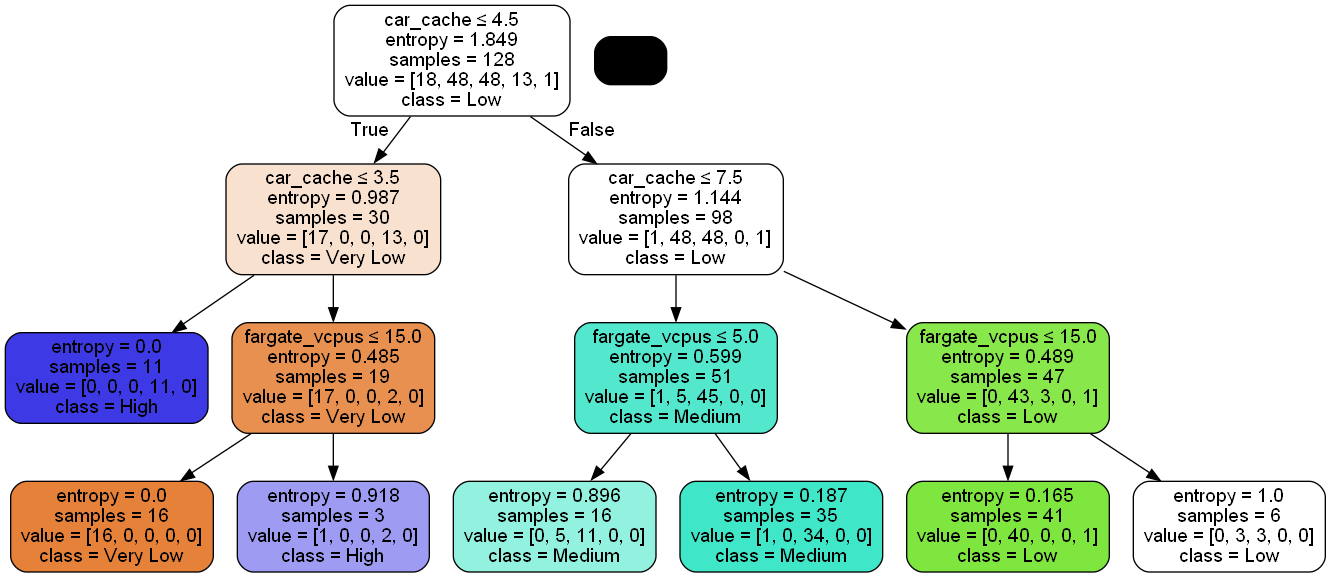

In [26]:
dot_data = export_graphviz(clf, out_file=None, feature_names=feature_cols, class_names=bin_labels, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.set_graphviz_executables({'dot': 'C:/Program Files/Graphviz/bin/dot.exe'})

Image(graph.create_png())

In [27]:
df.car_cache.unique()

array([ 9,  6,  7,  4,  5,  1,  3,  2, 10,  8], dtype=int64)